In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import pandas as pd

from scipy.io import mmread
from veloproj import *

scv.settings.verbosity = 1


In [2]:
def integrate_dataset():
    adata = scanpy.read_loom("/data/groups/yhhuang/veloData/bone_marrow/SCG71.loom")
    l_pcs = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/pca.csv", index_col=0)
    l_genes = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/genes.csv", index_col=0)
    l_filtered_cells = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/filtered_cells.csv", index_col=0)
    l_clusters = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/cluster.csv", index_col=0)
    l_tsne = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/embeddings.csv", index_col=0)

    raw_cells = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/raw_mtx_cells.csv", index_col=0)
    raw_genes = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/raw_mtx_genes.csv", index_col=0)
    raw_counts = mmread("/data/groups/yhhuang/veloData/bone_marrow/raw_counts.mtx").tocsr().T

    gene_idx = np.intersect1d(l_genes, raw_genes)
    cell_idx = np.intersect1d(adata.obs_names, l_filtered_cells.x.values) # intersection is l_filterred cells
    adata = adata[l_filtered_cells.x.values] # adata[l_filtered_cells.x.values]
    adata.obs['cluster'] = l_clusters.x.values
    adata.obsm['X_umap'] = l_tsne[['V1','V2']].values
    adata.obsm['X_pca'] = l_pcs.values
    adata = adata[:, gene_idx]

    raw_gene_dict = {gene:i for i,gene in enumerate(raw_genes.x.values)}
    raw_gene_indices = [raw_gene_dict[gene] for gene in gene_idx]
    raw_cell_dict = {cell:i for i, cell in enumerate(raw_cells.x.values)}
    raw_cell_indices = [raw_cell_dict[cell.split(":")[-1]] for cell in cell_idx]
    adata.X = raw_counts[raw_cell_indices][:, raw_gene_indices]

    adata.obsm['X_umap'] = (np.array([[0,-1],[1, 0]]) @ adata.obsm['X_umap'].T).T
    adata.obsm['X_umap'][:, 0] *= -1
    # adata.X = adata.layers['spliced'] + adata.layers['unspliced']
    print(adata)
    return adata


def get_selection(labels):
    sel = np.zeros(adata.n_obs,  dtype=np.bool)
    for lab in labels:
        sel = sel | (adata.obs.cluster == lab).values
    return sel

def annotate_cells():
    cluster_names = np.array(["              "]* adata.n_obs)
    label_list = [[7, 2], [1], [3], [5], [4, 6, 8]]
    cell_types = ['activating', 'dividing', 'progenitors', 'B cell lineage', 'macrophages']
    for labels, name in zip(label_list, cell_types):
        sel = get_selection(labels)
        cluster_names[sel] = name
    return cluster_names   

In [3]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'mousebonemarrow_model.cpt',
                               '--exp-name', 'CohAE_mousebonemarrow',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', 'SU',
                               '--ld_nb_g_src', 'SU',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'true', 
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'cell_type',
                               '--scv_n_jobs', '10',
                              ])

args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_mousebonemarrow', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='SU', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='mousebonemarrow_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=True, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='cell_type', weight_decay=0.0, z_dim=100)

In [4]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [5]:
cluster_edges = [('dividing', 'progenitors'), ('progenitors', 'activating')]
EXP_NAME = args.exp_name
exp_metrics = {}

In [6]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [7]:
adata = integrate_dataset()
adata.obs['cell_type'] = annotate_cells()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata,
                            n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

AnnData object with n_obs × n_vars = 2600 × 21552
    obs: 'cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
Abundance of ['spliced', 'unspliced']: [0.91 0.09]
AnnData object with n_obs × n_vars = 2600 × 2000
    obs: 'cluster', 'cell_type', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/2600 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_mousebonemarrow_stc.png


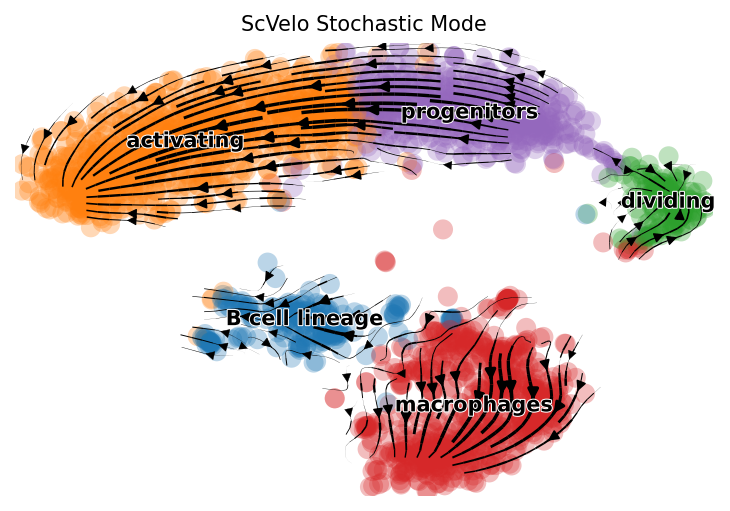

# Cross-Boundary Transition Score (A->B)
{('dividing', 'progenitors'): 0.08081106, ('progenitors', 'activating'): 0.2549142}
Total Mean: 0.16786262392997742
# Cross-Boundary Velocity Coherence (A->B)
{('dividing', 'progenitors'): 0.54570127, ('progenitors', 'activating'): 0.55116165}
Total Mean: 0.5484314560890198
# Cross-Boundary Direction Correctness (A->B)
{('dividing', 'progenitors'): 0.10143336452686896, ('progenitors', 'activating'): 0.8167700594157323}
Total Mean: 0.4591017119713007
# In-cluster Coherence
{'B cell lineage': 0.7634336, 'activating': 0.6522171, 'dividing': 0.6548008, 'macrophages': 0.67429566, 'progenitors': 0.6170607}
Total Mean: 0.6723614931106567
# In-cluster Confidence
{'B cell lineage': 0.6944683394555388, 'activating': 0.7036677280780144, 'dividing': 0.6736017243676288, 'macrophages': 0.7089355033545408, 'progenitors': 0.6368782520844047}
Total Mean: 0.6835103094680254


In [8]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="stc_velocity", 
                                basis=args.vis_key, color=args.vis_type_col,
                                dpi=150, 
                                save="mousebonemarrow_stc.png",
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Loss: (Total) 0.090240, (AE) 0.089954, (LR) 1.00 * 0.000286: 100%|██████████| 20000/20000 [18:00<00:00, 18.51it/s]


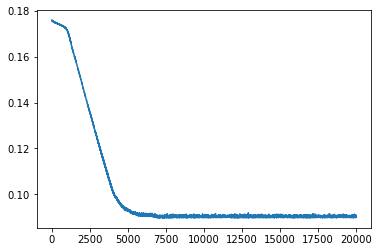

In [9]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/2600 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_mousebonemarrow_pojection.png


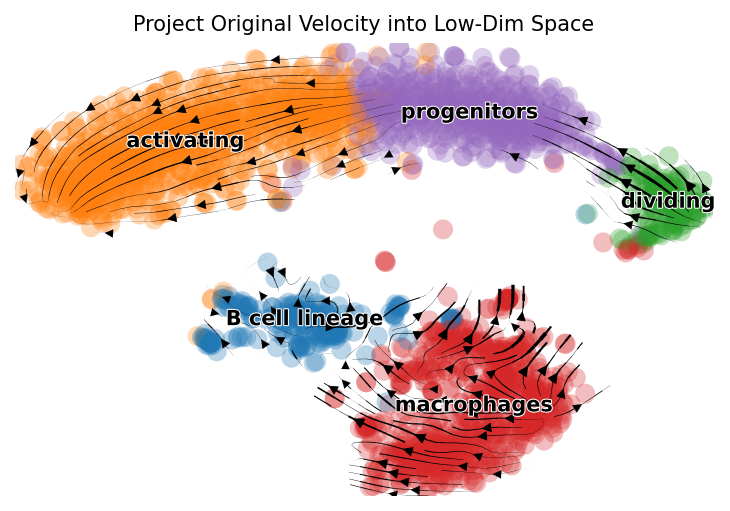

# Cross-Boundary Transition Score (A->B)
{('dividing', 'progenitors'): 0.7386567, ('progenitors', 'activating'): 0.20166536}
Total Mean: 0.4701610207557678
# Cross-Boundary Velocity Coherence (A->B)
{('dividing', 'progenitors'): 0.66704315, ('progenitors', 'activating'): 0.8253081}
Total Mean: 0.7461756467819214
# Cross-Boundary Direction Correctness (A->B)
{('dividing', 'progenitors'): 0.8235606287498806, ('progenitors', 'activating'): 0.18012615842300475}
Total Mean: 0.5018433935864427
# In-cluster Coherence
{'B cell lineage': 0.8569012, 'activating': 0.8923504, 'dividing': 0.9650877, 'macrophages': 0.96622956, 'progenitors': 0.87603456}
Total Mean: 0.911320686340332
# In-cluster Confidence
{'B cell lineage': 0.7193787410566262, 'activating': 0.8709607958781452, 'dividing': 0.8694573737761025, 'macrophages': 0.898196365203796, 'progenitors': 0.8507972245011822}
Total Mean: 0.8417581000831704


In [10]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.pp.neighbors(adata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata,
                                    vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=150,
                                    save='mousebonemarrow_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
exp(adata, exp_metrics)

AnnData object with n_obs × n_vars = 2600 × 21552
    obs: 'cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
Abundance of ['spliced', 'unspliced']: [0.91 0.09]


  0%|          | 0/461 [00:00<?, ?gene/s]

  0%|          | 0/2600 [00:00<?, ?cells/s]

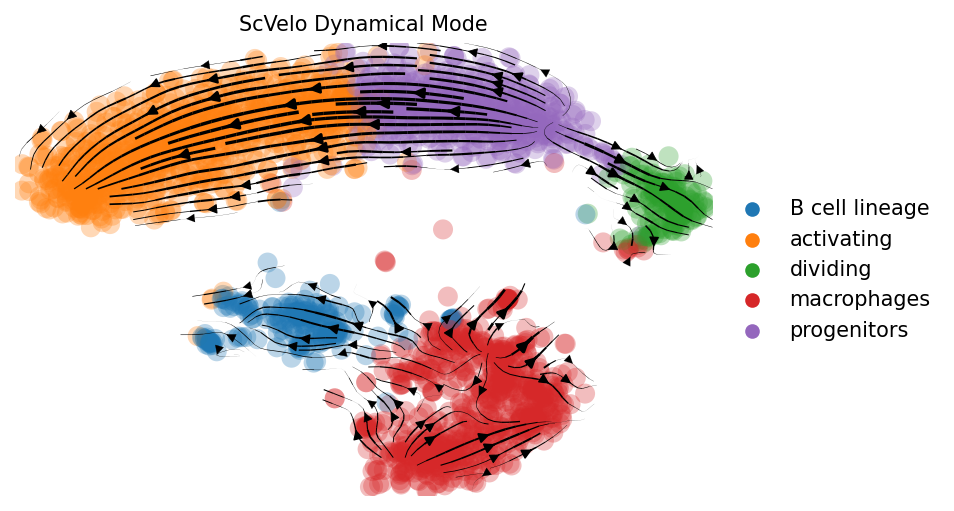

# Cross-Boundary Transition Score (A->B)
{('dividing', 'progenitors'): 0.024235932, ('progenitors', 'activating'): 0.3646083}
Total Mean: 0.19442211091518402
# Cross-Boundary Velocity Coherence (A->B)
{('dividing', 'progenitors'): 0.8730488424942832, ('progenitors', 'activating'): 0.9576401598075538}
Total Mean: 0.9153445011509185
# Cross-Boundary Direction Correctness (A->B)
{('dividing', 'progenitors'): -0.7924966500141554, ('progenitors', 'activating'): 0.708512985908321}
Total Mean: -0.04199183205291718
# In-cluster Coherence
{'B cell lineage': 0.8186807172136471, 'activating': 0.9376292810288561, 'dividing': 0.9400300529894638, 'macrophages': 0.8187928478747195, 'progenitors': 0.9579076941602012}
Total Mean: 0.8946081186533776
# In-cluster Confidence
{'B cell lineage': 0.7973245166183787, 'activating': 0.9355059106009787, 'dividing': 0.9319744203920083, 'macrophages': 0.8080525368765921, 'progenitors': 0.9563820127799184}
Total Mean: 0.8858478794535752


In [11]:
adata = integrate_dataset()
adata.obs['cell_type'] = annotate_cells()

scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)